# Visualising chemical space

Humans like to visualise and find patterns, who doesn't like a good regression trend like in notebook 1. When it comes to visualising chemical space, which is highly complex, it's no different. Ofcourse humans cannot visualise more than a handful of dimensions (3D x,y,z, then colour, size, shading, let's say 6d max and things are already uncomfortably complex then), and chemcial space has hundreds of thousands of dimensions using the encodings we have discusssed here.

To get around this typically chemists have turned to dimensionality reduction techniques to distill most of the variance present between molecules down to a handful of dimensons to visualise, which can be informative. note KNN is almost always outcompeted by other algorhtms, so although pointing and saying "ooh look, this cluster is active, but that cluster is not" while it can inform decision making, the reality is liekly more complex and smaller changes to molecules need to be considered.

Enough talking, let's jump into our first example:
- HIV1 protease inhibitor dataset
- ecfp3 encoding, as its a nice 1024 member vector
- using python, sklearn, pandas, numpy and rdkit as previously

In [23]:
### import libraries & data

In [24]:
# general
import os
from multiprocessing import Pool
import random

# data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# cheminformatics
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import deepchem as dc

df = pd.read_table('lib/data/2_hiv_protease.tsv')
# some entries are missing label values
df = df[df['Standard Value'] > 0]
# there are duplicate values, let's get the mean Ki per smiles
df = pd.DataFrame( df.groupby(['Smiles'])['Standard Value'].mean() )
# now the Ki values are very diverse, let's take the log10 transform
data = {'smiles': df['Standard Value'].index,
        'pKi': np.log10(df['Standard Value'].values)}
df_orig = pd.DataFrame(data)
df = df_orig[0:200]
y = df['pKi']
df

,smiles,pKi
0,C#CCN1C(=O)N(CC#C)[C@H](Cc2ccccc2)[C@@H]2OC(C)...,1.342423
1,C#CCN1C(=O)N(CC#C)[C@H](Cc2ccccc2)[C@H](O)[C@@...,1.342423
2,C/C(=C\C(=O)N(C)[C@@H](Cc1ccccc1)[C@H](O)CN(Cc...,1.720490
3,C/C(=N/O)c1cccc(CN2C(=O)N(Cc3cccc(/C(C)=N/O)c3...,-1.744727
4,C/C(=N/O)c1cccc(CN2[C@H](COc3ccccc3)[C@H](O)[C...,0.531479
...,...,...
195,CC(C)(C)OC(=O)N[C@@H](Cc1ccccc1)[C@@H](O)[C@@H...,1.903090
196,CC(C)(C)OC(=O)N[C@@H](Cc1ccccc1)[C@@H](O)[C@@H...,11.778968
197,CC(C)(C)OC(=O)N[C@@H](Cc1ccccc1)[C@@H](O)[C@@H...,11.890000
198,CC(C)(C)OC(=O)N[C@@H](Cc1ccccc1)[C@@H](O)[C@@H...,10.900000


### cheminformatics

In [25]:
def smiles_2_ecfp4(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol,4,nBits=1024,useFeatures=True)
    arr = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return(arr)

with Pool(processes=os.cpu_count()) as p:
    x_ecfp4 = np.stack(p.map(smiles_2_ecfp4, df.smiles.values))

### visualisation 1 - Principle Component Analysis (PCA)

Now we have our dataset let's try a typical first dimensionality reduction technique that every data sceintist and statistician, heck scientist is familiar with, the PCA.

Given ecfp4's 1024 dimensions, if the top dimension after PCA accoounts for 1% of the total variance, that's a ~10* boost on no compression. keep that in mind.

Proportion of variance in top3 dimensions:
[0.07823053 0.06441484 0.0573524 ]


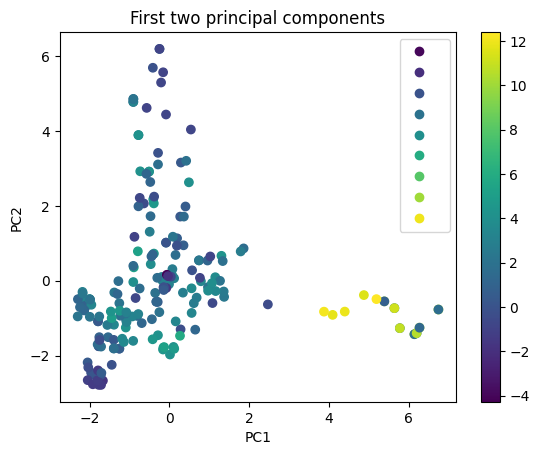

In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)

# how much variance de each of the top 3 components contain?
pca.fit(x_ecfp4)
print("Proportion of variance in top3 dimensions:")
print(pca.explained_variance_ratio_)

# cool it's doing something, let's plot
df_pca = pca.fit_transform(x_ecfp4)

f, ax = plt.subplots()
plot = plt.scatter(df_pca[:,0], df_pca[:,1], c=y)
plt.legend(handles=plot.legend_elements()[0])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("First two principal components")
f.colorbar(plot)
plt.show()

We can see here that the ki values of molecules is quite "clumpy". What I mean by that is that it appears that you have some clear regions of strong inhibitions, and other regions of weak inhibition, that are clear. Then a minority of patches where things are more grey. This may explain why KNN, a simple and usually poorly effective algorithm worked so well!

Let's try adding more molecules and see if this holds

Proportion of variance in top3 dimensions:
[0.08386106 0.05724291 0.03788813]


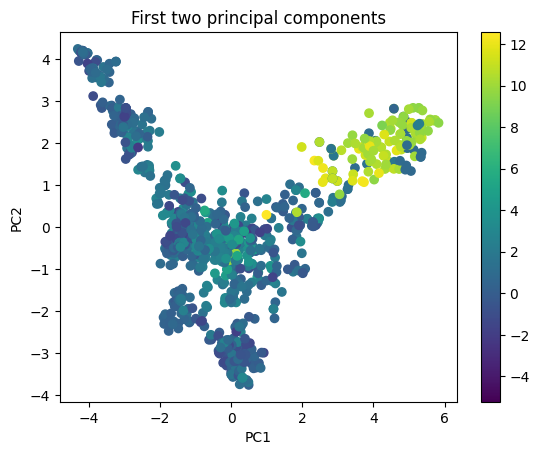

In [33]:
df = df_orig[0:1000]
y = df['pKi']
def smiles_2_ecfp4(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol,4,nBits=1024,useFeatures=True)
    arr = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return(arr)

with Pool(processes=os.cpu_count()) as p:
    x_ecfp4 = np.stack(p.map(smiles_2_ecfp4, df.smiles.values))

from sklearn.decomposition import PCA
pca = PCA(n_components=3)

# how much variance de each of the top 3 components contain?
pca.fit(x_ecfp4)
print("Proportion of variance in top3 dimensions:")
print(pca.explained_variance_ratio_)

# cool it's doing something, let's plot
df_pca = pca.fit_transform(x_ecfp4)

plot = plt.scatter(df_pca[:,0], df_pca[:,1], c=y)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("First two principal components")
plt.colorbar(plot)
plt.show()

huh well this is looking a little more interesting, let's stick to 1000 molecules and try some more dimensonality reduction techniques shall we?


### visualisation 2 - t-SNE
T-distributed Stochastic Neighbor Embedding

tsne uses a radicaly different apprach to PCA, it forces as much variance as it can into the number of dimensions specified. The maths is a little involved .. which is another way of saying , the maths looks hard, I'm not tottally able to follow it, this is a short tutorial, please go ask someone else!
What I do know, is that by twweaking the perplexity parameter, you can get wildly different looking plots, but points that are close in one, tend to be close in another.

tSNE is from a family of apprahces that tend to force "clusters" of points.

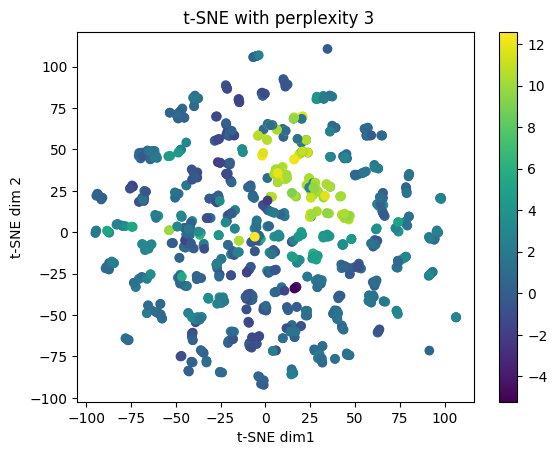

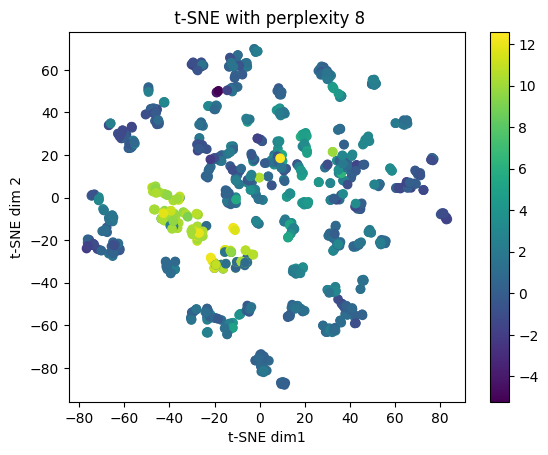

In [34]:
from sklearn.manifold import TSNE

df_tsne = TSNE(n_components=2, learning_rate='auto',
               init='random', perplexity=3).fit_transform(x_ecfp4)

plot = plt.scatter(df_tsne[:,0], df_tsne[:,1], c=y)
plt.xlabel("t-SNE dim1")
plt.ylabel("t-SNE dim 2")
plt.title(" t-SNE with perplexity 3")
plt.colorbar(plot)
plt.show()


df_tsne = TSNE(n_components=2, learning_rate='auto',
               init='random', perplexity=8).fit_transform(x_ecfp4)

plot = plt.scatter(df_tsne[:,0], df_tsne[:,1], c=y)
plt.xlabel("t-SNE dim1")
plt.ylabel("t-SNE dim 2")
plt.title(" t-SNE with perplexity 8")
plt.colorbar(plot)
plt.show()

now the point that I find most intruiging is that yellow dot, in an otherwise sea of bluey-yellow. Why is that molecule particularly potent? is there some small change to an otherwise meh framework we can learn from?  

### visualisation 3 - UMAP

UMAP is similar in a way to t-SNE, but much more computationally efficient and has become the modern go-to. It's short description, is that it also tries to put all the variance into n dimensions, but it does this by randomly sampling a set of points, calculating how distant they should be from one another, then slightly altering their x and y positions accordlingly, "you're more like those blue points over there, and way way different to that purple point, I'm moving you a fraction in that direction". Rinse and repeat many millions of times, and hey presto you have UMAP!

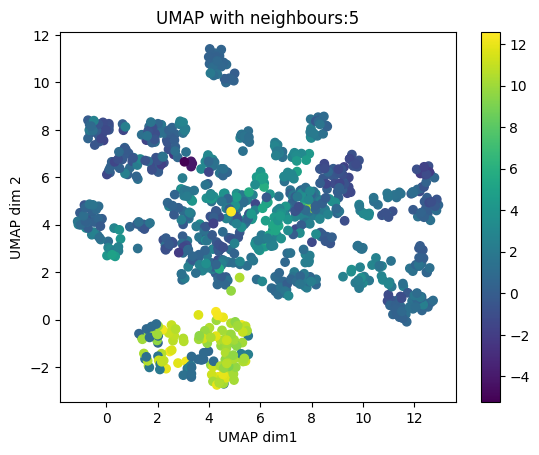

In [44]:
import umap

df_umap = trans = umap.UMAP(n_neighbors=40, min_dist= 0.6, random_state=42).fit(x_ecfp4)

plot = plt.scatter(df_umap.embedding_[:, 0], df_umap.embedding_[:, 1], c=y)
plt.xlabel("UMAP dim1")
plt.ylabel("UMAP dim 2")
plt.title("UMAP with neighbours:5")
plt.colorbar(plot)
plt.show()

### Summary 

In this notebook we have looked at visualising the chemical space of the HIV1 protease inhibitors we have been working with. 

By visualising the first 1000 molecules we can see that clearly there are regions of this space that have little to no activity, whilst other regions are more interesting biologically. 


